In [1]:
from __future__ import annotations

from functools import partial
from typing import Literal

import jax
import jax.numpy as jnp
import jax.scipy.stats as jstats
import matplotlib.pyplot as plt

In [2]:
ex_dir = jnp.array([1, 5, 1], dtype=jnp.float32)

In [ ]:
@partial(jax.jit, static_argnames=("keep",))
def condition_mv(mean, cov, val, keep: int = 0):
    val = jnp.atleast_1d(val)
    m = mean.shape[0]
    c = val.shape[0]

    mu_1, mu_2 = mean[:-c], mean[-c:]
    cov_11 = cov[:-c, :-c].reshape((m - c, m - c))
    cov_12 = cov[:-c, -c:].reshape((m - c, c))
    cov_22 = cov[-c:, -c:].reshape((c, c))
    term = cov_12 @ jnp.linalg.inv(cov_22)
    cov_star = cov_11 - term @ cov_12.T
    mu_star = mu_1 + term @ (val - mu_2)
    if keep:
        mu_star = jnp.concat((mu_star, val[:keep]))
        cov_star = jnp.pad(cov_star, ((0, keep), (0, keep)))

    assert mu_star.shape == (m - c + keep,), f"{mu_star.shape=}"
    assert cov_star.shape == (m - c + keep, m - c + keep), f"{cov_star.shape=}"
    return mu_star, cov_star

In [3]:
@jax.jit
def condition_subspace(cov: jnp.ndarray, orthog_dir: jnp.ndarray, val: float):
    dim = orthog_dir.shape[0]
    assert orthog_dir.shape == (dim,)
    assert cov.shape == (dim, dim), f"{cov.shape=}"

    expand = jnp.concat((jnp.identity(dim), orthog_dir.reshape((1, -1))), axis=0)
    mean = jnp.zeros((dim + 1,))
    cov = expand @ cov @ expand.T
    return condition_mv(mean, cov, val, keep=0)


ex_cov = jnp.array([[2, 1, 1], [1, 2.4, 0], [1, 0, 1.5]], dtype=jnp.float32)
ex_mean, ex_cov = condition_subspace(
    cov=ex_cov,
    orthog_dir=ex_dir,
    val=1.2,
)

In [4]:
map_a, map_b = 0.08163265, 0.64114136


@partial(jnp.vectorize, signature="(x),(z)->(x,z)")
@jax.jit
def wavy_kernel(x: jnp.ndarray, y: jnp.ndarray):
    return (1 + x.reshape((-1, 1)) @ y.reshape((1, -1))) ** 2 + map_a * (
        jnp.sin(2 * jnp.pi * x.flatten() + map_b).reshape((-1, 1))
        * jnp.sin(2 * jnp.pi * y.flatten() + map_b).reshape((1, -1))
    )

In [5]:
@partial(jax.jit, static_argnames=("l_size", "sample_shape"))
def gen_unconditional_samples(
    key: jnp.ndarray,
    orthog_dir: jnp.ndarray,
    q_hat: float,
    l_size: int,
    sample_shape: tuple[int, ...],
):
    space = jnp.linspace(0, 1, num=l_size)
    mean = jnp.zeros_like(space)
    cov = wavy_kernel(space, space)
    if orthog_dir is not None:
        mag = jnp.linalg.norm(orthog_dir)
        mean, cov = condition_subspace(
            cov=cov, orthog_dir=orthog_dir / mag, val=q_hat / mag
        )
    samples = jax.random.multivariate_normal(key, mean, cov, sample_shape, method="svd")
    return samples

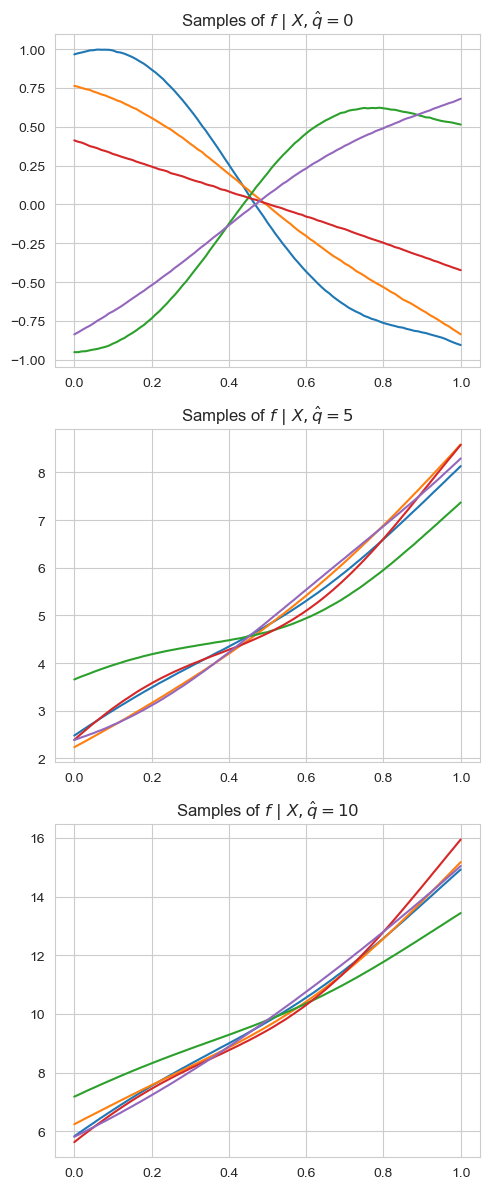

In [6]:
def plot_unconditional_samples(
    ax: plt.Axes = None,
    key: jnp.ndarray = None,
    orthog_dir: jnp.ndarray | Literal["w"] = None,
    q_hat: float = 1.0,
    l_size: int = 101,
    sample_shape: tuple[int, ...] = (5,),
):
    if orthog_dir == "w":
        orthog_dir = jnp.full((l_size,), 1 / (l_size - 1)).at[((0, -1),)].multiply(0.5)
    if key is None:
        key = jax.random.key(1)
    if ax is None:
        _, ax = plt.subplots()

    samples = gen_unconditional_samples(key, orthog_dir, q_hat, l_size, sample_shape)
    assert jnp.isfinite(samples).all(), "Invalid values sampled"
    for sample in samples:
        ax.plot(jnp.linspace(0, 1, l_size), sample, label="")

    if orthog_dir is not None:
        assert jnp.isclose(
            orthog_dir @ samples.reshape((-1, l_size)).T, q_hat, atol=0.01
        ).all(), f"Invalid conditioning, {orthog_dir @ samples.T}"
        ax.set_title(f"Samples of $f ~|~ X, \\hat q = {q_hat}$")
    else:
        ax.set_title("Unconditional samples of $f ~|~ X$")

    return samples


_, axs = plt.subplots(nrows=3, figsize=(5, 12), tight_layout=True)
for w_key, w_ax, target_q in zip(
    jax.random.split(jax.random.key(0), 3), axs, (0, 5, 10)
):
    plot_unconditional_samples(
        ax=w_ax, key=w_key, orthog_dir="w", q_hat=target_q, l_size=101
    )
plt.show()

In [9]:
def shuffle_condition(
    mean: jnp.ndarray,
    cov: jnp.ndarray,
    indices: jnp.ndarray,
    vals: jnp.ndarray,
    orthog_dir: jnp.ndarray = None,
    q_hat: float = 1.0,
):
    is_conditioned = (
        jnp.zeros_like(mean).at[(indices,)].set(1).argsort().reshape((-1, 1))
    )
    reverse_is = (
        jnp.empty_like(mean, dtype=jnp.int32)
        .at[is_conditioned.flatten()]
        .set(jnp.arange(0, len(is_conditioned)))
        .reshape((-1, 1))
    )
    mean, cov = mean[is_conditioned.flatten()], cov[is_conditioned, is_conditioned.T]
    if orthog_dir is not None:
        expand = jnp.concat(
            (jnp.identity(len(mean)), orthog_dir.reshape((1, -1))), axis=0
        )
        mean = expand @ mean
        cov = expand @ cov @ expand.T
        vals = jnp.concat((vals, jnp.array([q_hat], dtype=jnp.float32)))
    mean, cov = condition_mv(mean, cov, vals, keep=len(vals) - (orthog_dir is not None))
    mean, cov = mean[reverse_is.flatten()], cov[reverse_is, reverse_is.T]
    return mean, cov

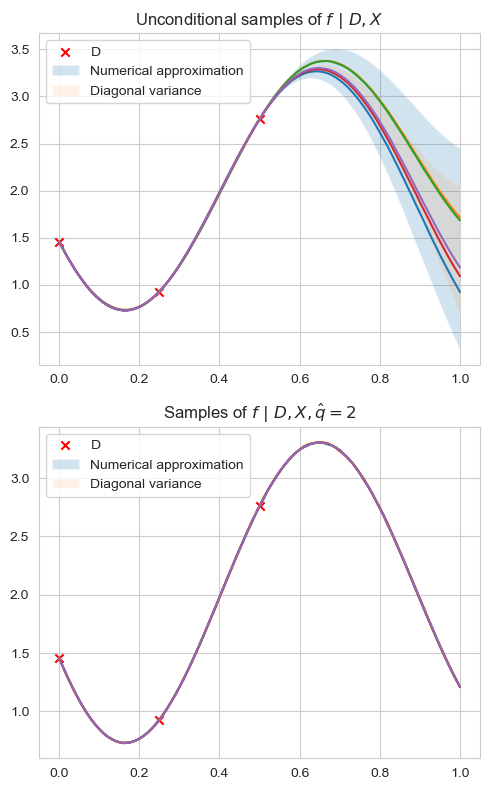

In [8]:
def conditional_samples(
    xs: jnp.ndarray,
    ys: jnp.ndarray,
    ax: plt.Axes = None,
    key: jnp.ndarray = None,
    l_size: int = 101,
    orthog_dir: jnp.ndarray | Literal["w"] = None,
    q_hat: float = 1.0,
    sample_shape: tuple[int, ...] = (5,),
):
    if key is None:
        key = jax.random.key(1)
    if ax is None:
        _, ax = plt.subplots()

    space = jnp.linspace(0, 1, num=l_size)
    mean = jnp.zeros_like(space)
    cov = wavy_kernel(space, space)
    # it's a bit hacky, but works in this case.
    indices = jnp.round(xs * 100).clip(0, 100).astype(jnp.int32)
    if orthog_dir is not None:
        if orthog_dir == "w":
            orthog_dir = (
                jnp.full_like(space, 1 / (l_size - 1)).at[((0, -1),)].multiply(0.5)
            )
        mag = jnp.linalg.norm(orthog_dir)
        mean, cov = shuffle_condition(
            mean, cov, indices, ys, orthog_dir=orthog_dir / mag, q_hat=q_hat / mag
        )
        ax.set_title(f"Samples of $f ~|~ D, X, \\hat q = {q_hat}$")
    else:
        ax.set_title("Unconditional samples of $f ~|~ D, X$")
        mean, cov = shuffle_condition(mean, cov, indices, ys)

    samples = jax.random.multivariate_normal(key, mean, cov, sample_shape, method="svd")
    assert jnp.isfinite(samples).all(), "Invalid values sampled"
    ax.scatter(xs, ys, marker="x", c="red", label="D")
    for sample in samples:
        ax.plot(space, sample, label="")

    diag_low, diag_high = jstats.norm.ppf(
        jnp.array([0.05, 0.95]).reshape((2, 1)), loc=mean, scale=cov.diagonal()
    )
    error_samples = jax.random.multivariate_normal(
        key, mean, cov, (5000,), method="svd"
    )
    error_low, error_high = jnp.quantile(error_samples, jnp.array([0.05, 0.95]), axis=0)
    ax.fill_between(
        space, error_low, error_high, alpha=0.2, label="Numerical approximation"
    )
    ax.fill_between(space, diag_low, diag_high, alpha=0.1, label="Diagonal variance")
    ax.legend()

    if orthog_dir is not None:
        assert jnp.isclose(
            orthog_dir @ samples.reshape((-1, l_size)).T, q_hat, atol=0.01
        ).all(), f"Invalid conditioning, {orthog_dir @ samples.T}"
    global ex_dir
    ex_dir = orthog_dir
    return samples


data_xs = jnp.array([0, 0.25, 0.5], dtype=jnp.float32)
data_ys = jnp.array([1.46, 0.93, 2.76], dtype=jnp.float32)

_, axs = plt.subplots(nrows=2, figsize=(5, 8), tight_layout=True)
k1, k2 = jax.random.split(jax.random.key(42))
cs_1 = conditional_samples(data_xs, data_ys, l_size=101, q_hat=2, ax=axs[0], key=k1)
cs_2 = conditional_samples(
    data_xs, data_ys, l_size=101, q_hat=2, orthog_dir="w", ax=axs[1], key=k2
)